# **Overview:**

Chương trình này là tiếp nối của chương trình Part-2_Visualization.ipynb

Chương trình là thử nghiệm các mô hình Machine Learning trên tập dữ liệu đã được xử lý cũng như có cái nhìn tổng quan từ 2 phần trước.

# **6. Khai báo và cài đặt cần sử dụng**

In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from datetime import datetime
import warnings

In [85]:
from pylab import rcParams

rcParams['figure.figsize'] = 16,9

### **Đọc dữ liệu**

In [86]:
# from google.colab import drive
# drive.mount('data')

In [87]:
df = pd.read_csv('data/newProcessed22.csv')

In [88]:
df

,Index,Domain,Domain_Length,Subdomain_Level,Url_Length,Url_Depth,Have_At_Sign,Have_Tilde_Symbol,No_Https,Having_IP,...,DNS,Domain_Age,Domain_End,Rank_Host,Rank_Country,Iframe,Mouse_Over,Right_Click,Forwarding,Label
0,0,google.com,10,1,43,1,0,0,0,0,...,0,0,0,1,1,0,1,0,0,0
1,1,google.com,10,1,36,1,0,0,0,0,...,0,0,0,1,1,0,1,0,0,0
2,2,google.com,10,1,41,1,0,0,0,0,...,0,0,0,1,1,0,1,0,0,0
3,3,bilnet.eu,9,1,16,0,0,0,1,0,...,0,1,1,1,1,0,0,0,1,0
4,4,bil-privatebanking.eu,21,1,28,0,0,0,1,0,...,0,1,1,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13041,13041,formbuddy.com,13,1,56,2,0,0,1,0,...,0,0,0,1,1,0,0,0,0,1
13042,13042,formbuddy.com,13,1,61,2,0,0,1,0,...,0,0,0,1,1,0,0,0,0,1
13043,13043,habbocreditosparati.blogspot.com,32,1,44,0,0,0,1,0,...,1,1,1,1,1,0,0,0,0,1
13044,13044,creditiperhabbogratissicuro100.blogspot.com,43,1,95,3,0,0,1,0,...,1,1,1,1,1,0,0,0,0,1


**Kiểm tra độ quan trọng của đăc trưng (feature important)**

In [89]:
df.columns

Index(['Index', 'Domain', 'Domain_Length', 'Subdomain_Level', 'Url_Length',
       'Url_Depth', 'Have_At_Sign', 'Have_Tilde_Symbol', 'No_Https',
       'Having_IP', 'Domain_In_Subdomains', 'Domain_In_Paths',
       'Http_In_Hostname', 'Double_Slash_In_Path', 'Num_Dots',
       'Num_Dashes_In_Hostname', 'Num_Underscore', 'Num_Percent',
       'Num_Query_Components', 'Num_Ampersand', 'Num_Hash',
       'Num_Numeric_Chars', 'Path_Length', 'Query_Length',
       'Num_Sensitive_Words', 'Ext_Favicon', 'Redirection', 'Tiny_URL',
       'Prefix_Suffix', 'DNS', 'Domain_Age', 'Domain_End', 'Rank_Host',
       'Rank_Country', 'Iframe', 'Mouse_Over', 'Right_Click', 'Forwarding',
       'Label'],
      dtype='object')

In [90]:
features = ['Domain_Length', 'Subdomain_Level', 'Have_At_Sign', 'Have_Tilde_Symbol', 'No_Https', 'Having_IP', 'Domain_In_Subdomains', 'Domain_In_Paths', 'Http_In_Hostname', 'Double_Slash_In_Path', 'Num_Dots', 'Num_Dashes_In_Hostname', 'Num_Underscore', 'Num_Percent', 'Num_Query_Components', 'Num_Ampersand', 'Num_Hash', 'Num_Numeric_Chars', 'Path_Length', 'Query_Length', 'Num_Sensitive_Words', 'Ext_Favicon', 'Redirection', 'Tiny_URL', 'Prefix_Suffix', 'DNS', 'Domain_Age', 'Domain_End', 'Rank_Host', 'Rank_Country', 'Iframe', 'Mouse_Over', 'Right_Click', 'Forwarding']

In [91]:
X = df[features]
y = df['Label']

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostClassifier
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor()

In [94]:
rf.feature_importances_

array([2.32712679e-01, 0.00000000e+00, 1.43306440e-02, 1.10479330e-03,
       3.28844547e-02, 2.19913679e-04, 2.66736004e-02, 6.66121589e-04,
       1.41539312e-07, 7.99448047e-04, 5.99240922e-02, 3.32610558e-02,
       1.66116357e-02, 5.25889185e-03, 5.85178190e-03, 5.92287349e-03,
       5.77168390e-03, 8.74476049e-02, 1.84727195e-01, 8.46140155e-02,
       1.68123484e-02, 0.00000000e+00, 4.93814176e-03, 1.79496940e-02,
       2.56979307e-02, 8.86965610e-03, 2.71173758e-02, 3.56819859e-02,
       2.23438174e-02, 3.72643658e-03, 9.03691864e-03, 7.05012848e-03,
       1.04217396e-02, 1.15711998e-02])

<BarContainer object of 34 artists>

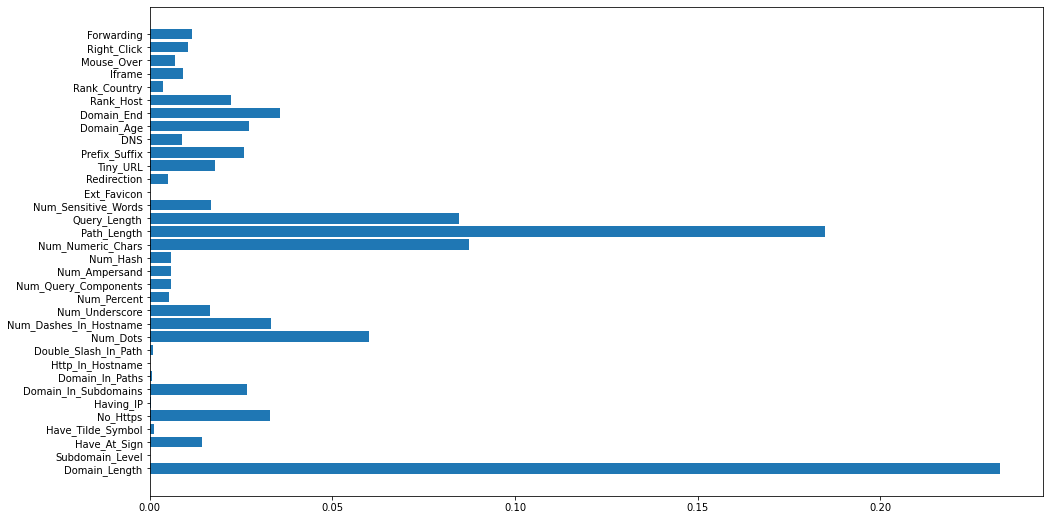

In [95]:
plt.barh(features, rf.feature_importances_)

# **7. Huấn luyện mô hình - Classification**

**Split dataset**

In [96]:
Y = y

In [97]:
from sklearn.model_selection import train_test_split

In [98]:
X_train,X_test,Y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [99]:
print('Kích thước tập huấn luyện: ', X_train.shape, Y_train.shape)
print('Kích thước tập kiểm tra: ', X_test.shape, y_test.shape)

Kích thước tập huấn luyện:  (10436, 34) (10436,)
Kích thước tập kiểm tra:  (2610, 34) (2610,)


In [100]:
# Hàm tính độ chính xác, ma trận nhầm lẫn, Recall, precision, f1 score và vẽ đồ thị ROC
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def evaluate_model(model, X_test, y_test, y_prediction):
    print("Các chỉ số đánh giá mức độ hiệu quả của mô hình: ")
    #Accuracy
    print("1. Accuracy:",metrics.accuracy_score(y_prediction,y_test))
    # confusion_matrix
    print('2. confusion_matrix:')
    confusionMatrix = confusion_matrix(y_prediction,y_test)
    print(confusionMatrix)
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(confusionMatrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confusionMatrix.shape[0]):
        for j in range(confusionMatrix.shape[1]):
            ax.text(x=j, y=i,s=confusionMatrix[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()
    # recall_score
    print('3. recall_score: ', recall_score(y_prediction,y_test))
    # precision_score
    print('4. precision_score: ', precision_score(y_prediction,y_test))
    # f1_score
    print('5. f1_score: ', f1_score(y_prediction,y_test))
    # ROC plot
    print('6. Biểu đồ ROC của mô hình:')
    metrics.plot_roc_curve(model, X_test, y_test)
    plt.show()

**Logistic Regression**

In [101]:
# #Given smote, we have to do a little adjustment
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import cross_val_score

# logreg = LogisticRegression(fit_intercept=True, penalty='l2')
# logreg.fit(X_train, Y_train)

# logregprediction=logreg.predict(X_test)

# evaluate_model (logreg, X_test, y_test, logregprediction)

**Linear Discriminant Analysis**

In [102]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# lda = LinearDiscriminantAnalysis()
# lda.fit(X_train, Y_train)

# lda_prediction=lda.predict(X_test)

# evaluate_model (lda, X_test, y_test, lda_prediction)

**Gaussian Naive Bayes**

In [103]:
# from sklearn.naive_bayes import GaussianNB
# gnb = GaussianNB()
# gnb.fit(X_train, Y_train)

# gnbprediction=gnb.predict(X_test)

# evaluate_model (gnb, X_test, y_test, gnbprediction)

**Decision Tree Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8045977011494253
2. confusion_matrix:
[[1034  296]
 [ 214 1066]]


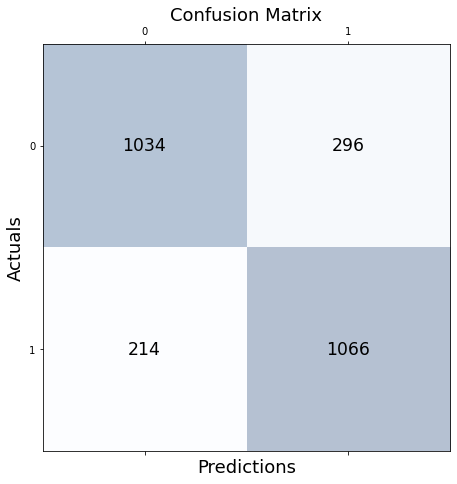

3. recall_score:  0.8328125
4. precision_score:  0.7826725403817915
5. f1_score:  0.8069644208932627
6. Biểu đồ ROC của mô hình:


C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


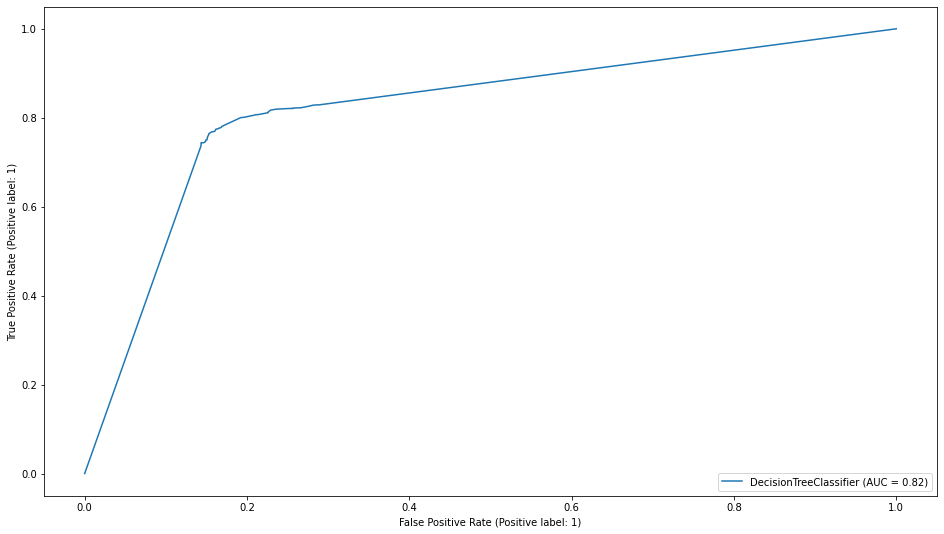

In [104]:
from sklearn.tree import DecisionTreeClassifier

dtc= DecisionTreeClassifier(random_state=72)
dtc.fit(X_train,Y_train)

dtcprediction=dtc.predict(X_test)

evaluate_model (dtc, X_test, y_test, dtcprediction)


**Random Forest Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8371647509578544
2. confusion_matrix:
[[1066  243]
 [ 182 1119]]


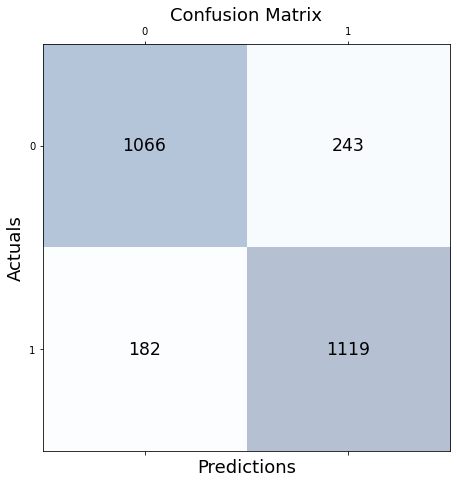

3. recall_score:  0.8601076095311299
4. precision_score:  0.8215859030837004
5. f1_score:  0.8404055576417574
6. Biểu đồ ROC của mô hình:


C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


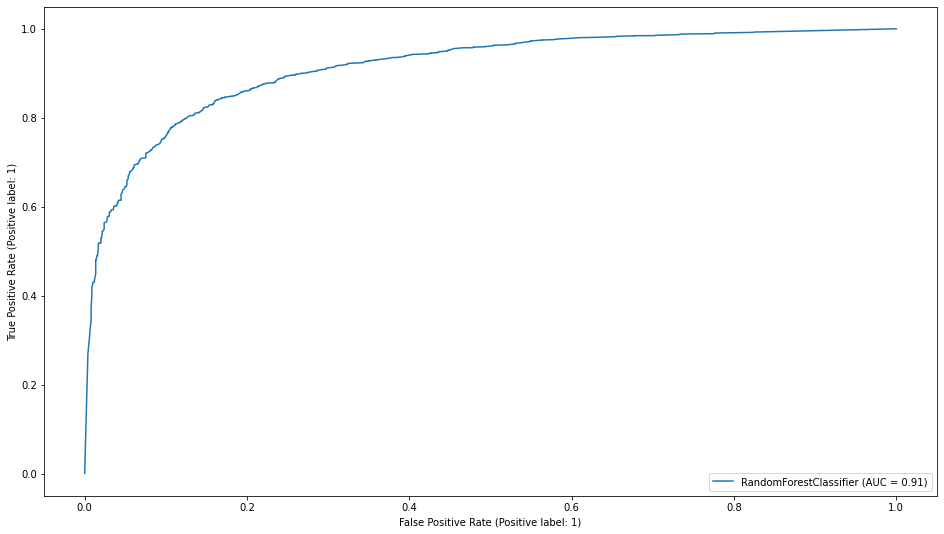

In [105]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(n_jobs=-1,random_state=43)
#learning
rfc.fit(X_train,Y_train)
#Prediction
rfcprediction=rfc.predict(X_test)

evaluate_model (rfc, X_test, y_test, rfcprediction)


**SVM Classifier**

In [106]:
# from sklearn import svm
# #making the instance
# svc = svm.SVC(random_state=123)
# #learning
# svc.fit(X_train,Y_train)
# #Prediction
# svcprediction=svc.predict(X_test)

# evaluate_model (svc, X_test, y_test, svcprediction)

**K-NearestNeighbours Classifier**

In [107]:
# from sklearn.neighbors import KNeighborsClassifier
# #making the instance
# knn = KNeighborsClassifier()
# #learning
# knn.fit(X_train,Y_train)
# #Prediction
# knnprediction=knn.predict(X_test)

# evaluate_model (knn, X_test, y_test, knnprediction)

**Ada Boost**

In [108]:
# from sklearn.ensemble import AdaBoostClassifier

# ada_model = AdaBoostClassifier(n_estimators=200, random_state=44)

# #learning
# ada_model.fit(X_train,Y_train)
# #Prediction
# ada_modelprediction=ada_model.predict(X_test)

# evaluate_model (ada_model, X_test, y_test, ada_modelprediction)

**XGB Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8329501915708812
2. confusion_matrix:
[[1062  250]
 [ 186 1112]]


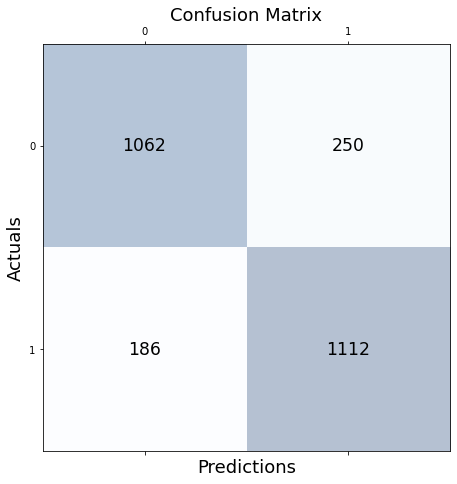

3. recall_score:  0.8567026194144838
4. precision_score:  0.8164464023494861
5. f1_score:  0.8360902255639098
6. Biểu đồ ROC của mô hình:


C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


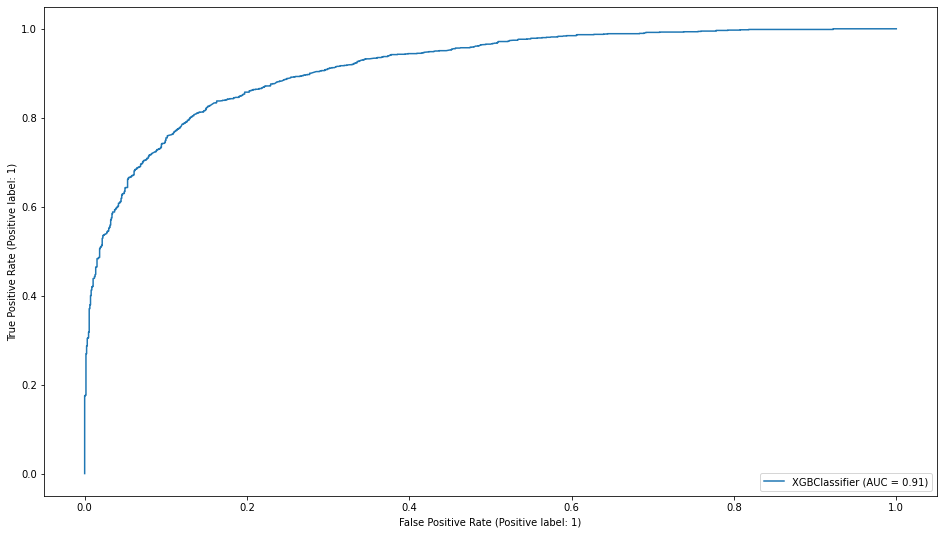

In [109]:
from xgboost import XGBClassifier

XGB_1 = XGBClassifier(objective='binary:logistic',scale_pos_weight=1,n_estimators=85, eta=0.3, subsample=1, colsample_bytree=1)

#learning
XGB_1.fit(X_train,Y_train)
#Prediction
XGB_modelprediction=XGB_1.predict(X_test)

evaluate_model (XGB_1, X_test, y_test, XGB_modelprediction)

**XGB Classifier Ver_2**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.831800766283525
2. confusion_matrix:
[[1063  254]
 [ 185 1108]]


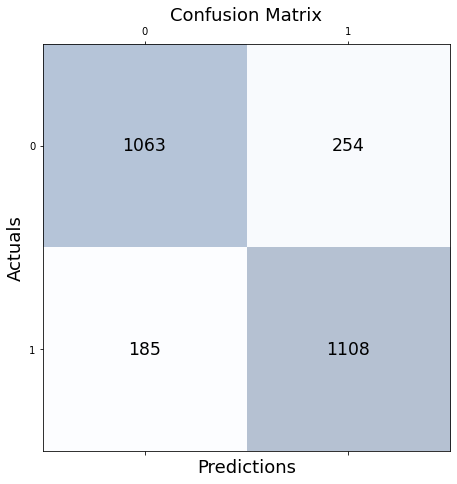

3. recall_score:  0.8569218870843001
4. precision_score:  0.8135095447870778
5. f1_score:  0.8346516007532956
6. Biểu đồ ROC của mô hình:


C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


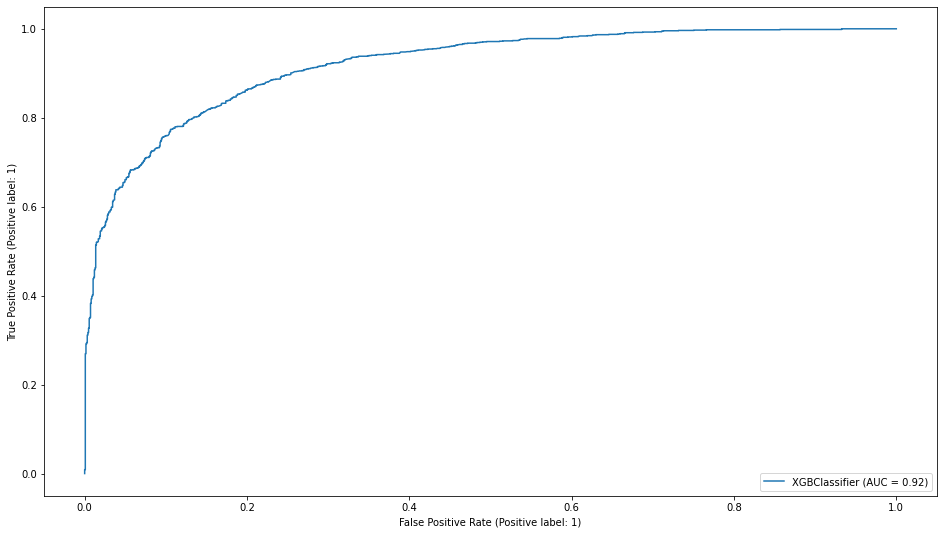

In [110]:
xgb_2 = XGBClassifier(learning_rate=0.4,max_depth=7)
#learning
xgb_2.fit(X_train,Y_train)
#Prediction
xgb_2_modelprediction_v2=xgb_2.predict(X_test)

evaluate_model (xgb_2, X_test, y_test, xgb_2_modelprediction_v2)

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.831800766283525
2. confusion_matrix:
[[1063  254]
 [ 185 1108]]


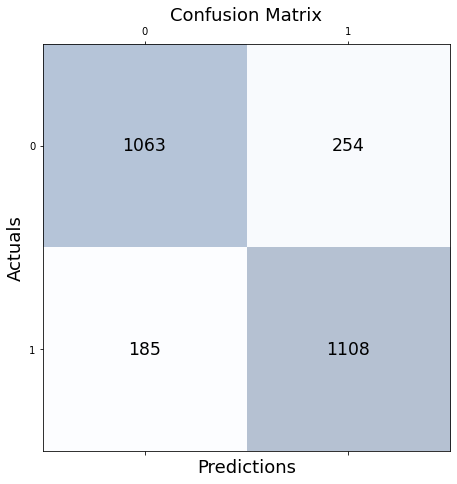

3. recall_score:  0.8569218870843001
4. precision_score:  0.8135095447870778
5. f1_score:  0.8346516007532956
6. Biểu đồ ROC của mô hình:


C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


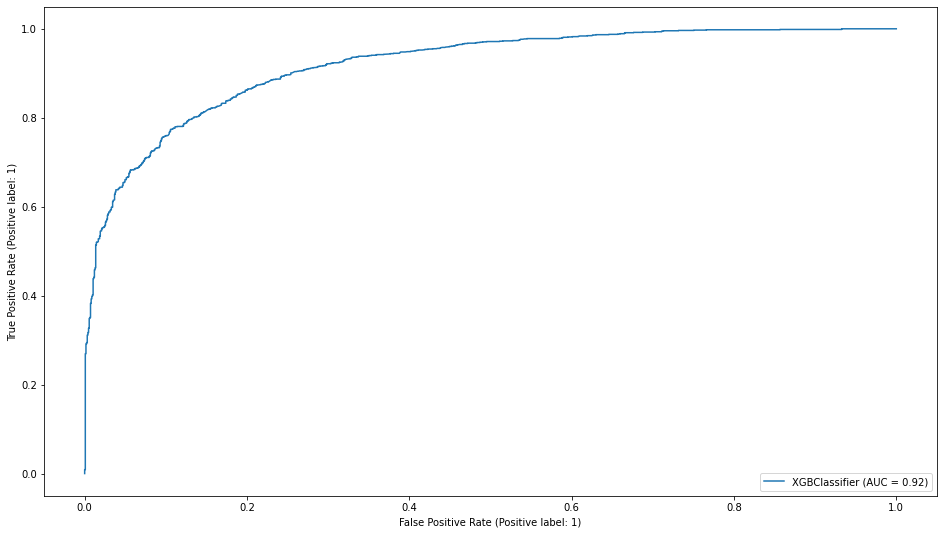

In [111]:
from xgboost import XGBClassifier

# instantiate the model
xgb_3 = XGBClassifier(learning_rate=0.4,max_depth=7)
#fit the model
xgb_3.fit(X_train, Y_train)

#predicting the target value from the model for the samples
y_test_xgb = xgb_3.predict(X_test)

evaluate_model (xgb_3, X_test, y_test, y_test_xgb)

**Light GBM**

In [112]:
# from lightgbm import LGBMClassifier

# lgbm_clf = LGBMClassifier(n_estimators=1000, objective='binary',
#                           class_weight={0:25, 1:1}, learning_rate=0.01,
#                           boosting_type='dart')
# lgbm_clf.fit(X_train, Y_train)

# #Prediction
# LGBM_modelprediction=lgbm_clf.predict(X_test)

# evaluate_model (lgbm_clf, X_test, y_test, LGBM_modelprediction)

**Voting Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8360153256704981
2. confusion_matrix:
[[1102  282]
 [ 146 1080]]


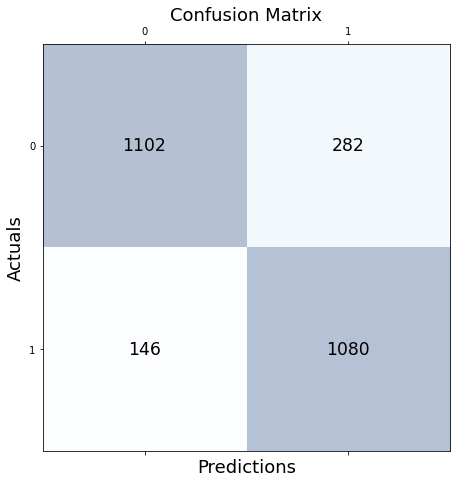

3. recall_score:  0.8809135399673735
4. precision_score:  0.7929515418502202
5. f1_score:  0.8346213292117465
6. Biểu đồ ROC của mô hình:


C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


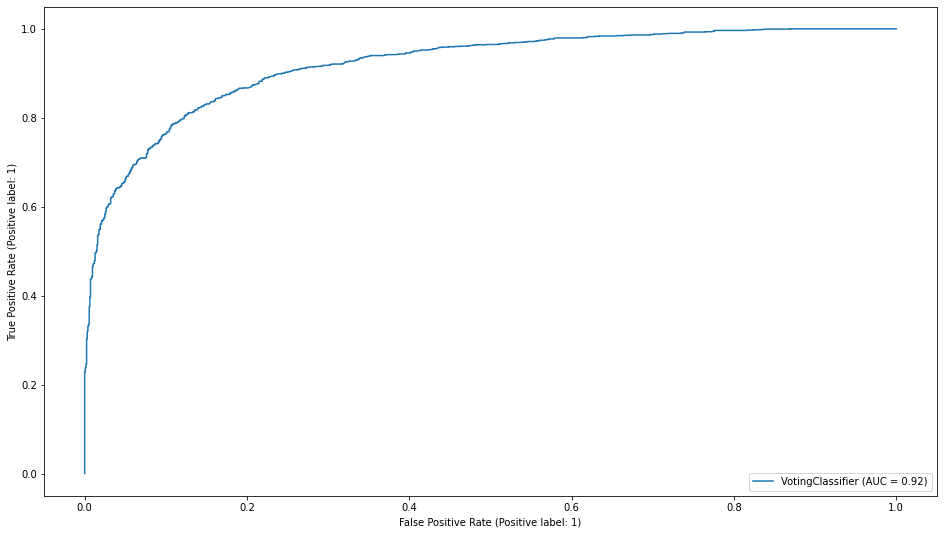

In [113]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
    ExtraTreesClassifier, VotingClassifier

clf1 = RandomForestClassifier(n_estimators=200, class_weight={0: 100, 1: 1})
clf2 = GradientBoostingClassifier(n_estimators=1000, max_depth=7)
clf3 = ExtraTreesClassifier(n_estimators=1000, class_weight={0: 100, 1: 1})
clf4 = XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=0.01)
pos_clf = VotingClassifier(estimators=[('pos', clf1), ('gb', clf2),
                                        ('et', clf3), ('xgb', clf4)],
                            voting='soft',
                            weights=[1, 2, 1, 1])

pos_clf.fit(X_train, Y_train)

#Prediction
Vot_modelprediction=pos_clf.predict(X_test)

evaluate_model (pos_clf, X_test, y_test, Vot_modelprediction)

**Gradient Boosting Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8337164750957854
2. confusion_matrix:
[[1056  242]
 [ 192 1120]]


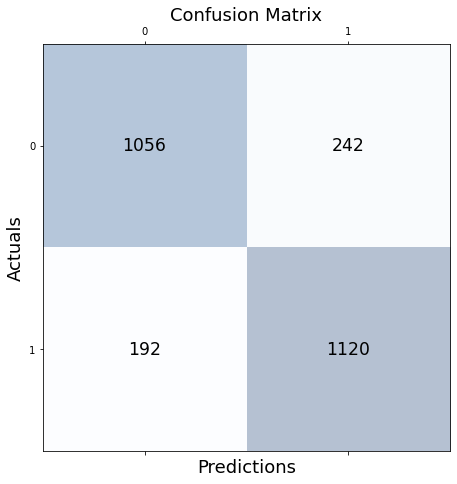

3. recall_score:  0.8536585365853658
4. precision_score:  0.8223201174743024
5. f1_score:  0.8376963350785339
6. Biểu đồ ROC của mô hình:


C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


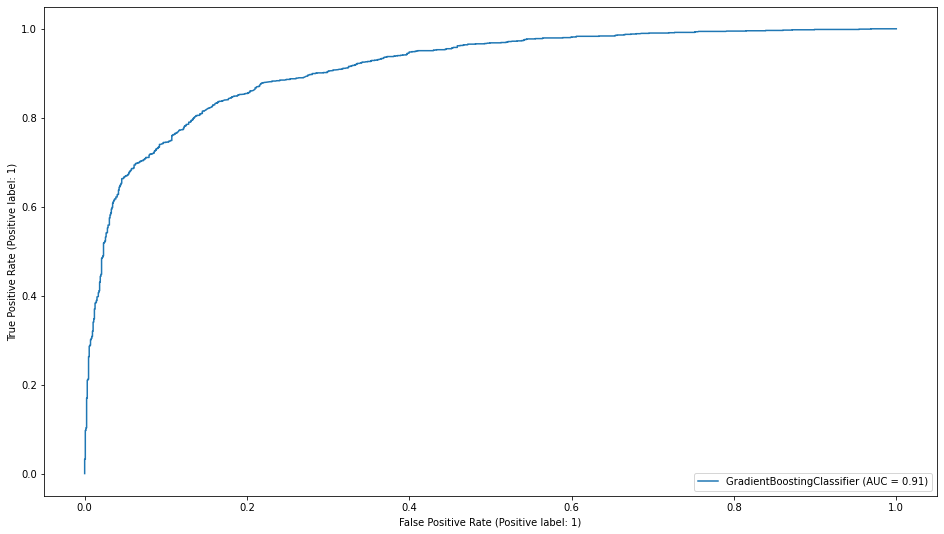

In [114]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
    ExtraTreesClassifier, VotingClassifier

GBoost = GradientBoostingClassifier(n_estimators=1000, max_depth=7)


GBoost.fit(X_train, Y_train)

#Prediction
GBoost_modelprediction=GBoost.predict(X_test)

evaluate_model (GBoost, X_test, y_test, GBoost_modelprediction)

**Extra Trees Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8180076628352491
2. confusion_matrix:
[[1098  325]
 [ 150 1037]]


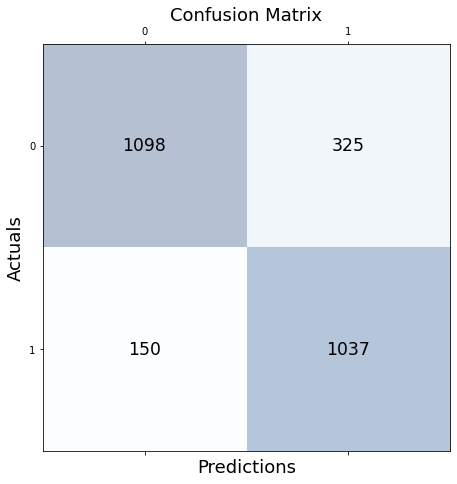

3. recall_score:  0.8736310025273799
4. precision_score:  0.7613803230543319
5. f1_score:  0.813652412710867
6. Biểu đồ ROC của mô hình:


C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


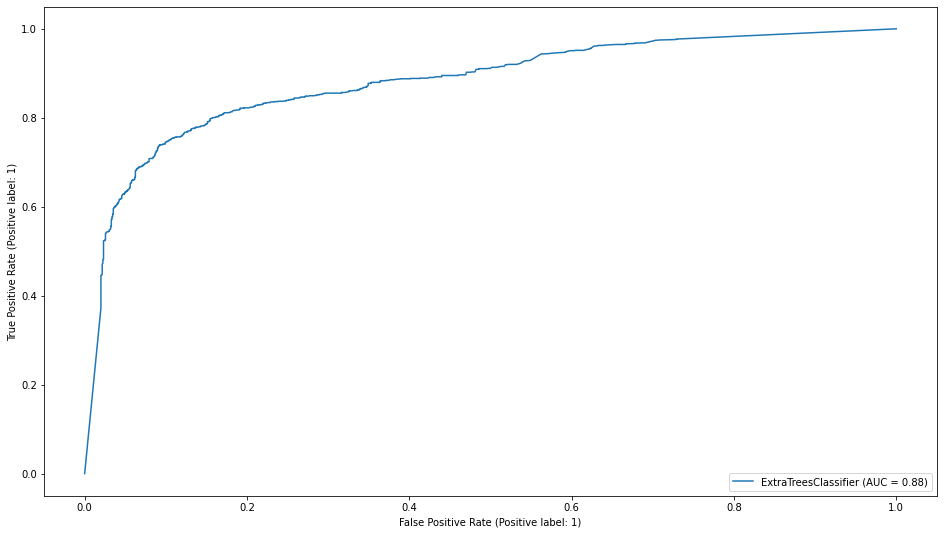

In [115]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
    ExtraTreesClassifier, VotingClassifier

Extra = ExtraTreesClassifier(n_estimators=1000, class_weight={0: 100, 1: 1})


Extra.fit(X_train, Y_train)

#Prediction
Extra_modelprediction=Extra.predict(X_test)

evaluate_model (Extra, X_test, y_test, Extra_modelprediction)

**Cat Boosting**

In [116]:
# pip install catboost

0:	learn: 0.6613562	total: 17ms	remaining: 17s
1:	learn: 0.6337067	total: 40.6ms	remaining: 20.3s
2:	learn: 0.6163864	total: 64ms	remaining: 21.3s
3:	learn: 0.5989057	total: 85.9ms	remaining: 21.4s
4:	learn: 0.5831416	total: 106ms	remaining: 21.2s
5:	learn: 0.5692779	total: 139ms	remaining: 23.1s
6:	learn: 0.5554844	total: 160ms	remaining: 22.7s
7:	learn: 0.5465455	total: 184ms	remaining: 22.8s
8:	learn: 0.5372219	total: 206ms	remaining: 22.7s
9:	learn: 0.5270038	total: 231ms	remaining: 22.8s
10:	learn: 0.5212862	total: 251ms	remaining: 22.6s
11:	learn: 0.5149138	total: 271ms	remaining: 22.3s
12:	learn: 0.5086872	total: 294ms	remaining: 22.3s
13:	learn: 0.5039034	total: 314ms	remaining: 22.1s
14:	learn: 0.4988641	total: 345ms	remaining: 22.7s
15:	learn: 0.4940374	total: 370ms	remaining: 22.8s
16:	learn: 0.4907496	total: 395ms	remaining: 22.8s
17:	learn: 0.4841206	total: 422ms	remaining: 23s
18:	learn: 0.4790956	total: 456ms	remaining: 23.6s
19:	learn: 0.4727099	total: 484ms	remaining: 

166:	learn: 0.3096262	total: 4.86s	remaining: 24.2s
167:	learn: 0.3092799	total: 4.88s	remaining: 24.2s
168:	learn: 0.3092736	total: 4.9s	remaining: 24.1s
169:	learn: 0.3085729	total: 4.92s	remaining: 24s
170:	learn: 0.3083158	total: 4.95s	remaining: 24s
171:	learn: 0.3077064	total: 4.97s	remaining: 23.9s
172:	learn: 0.3072398	total: 4.99s	remaining: 23.9s
173:	learn: 0.3069323	total: 5.02s	remaining: 23.8s
174:	learn: 0.3066321	total: 5.06s	remaining: 23.9s
175:	learn: 0.3061131	total: 5.11s	remaining: 23.9s
176:	learn: 0.3052898	total: 5.15s	remaining: 24s
177:	learn: 0.3045149	total: 5.17s	remaining: 23.9s
178:	learn: 0.3044799	total: 5.2s	remaining: 23.8s
179:	learn: 0.3041801	total: 5.22s	remaining: 23.8s
180:	learn: 0.3033791	total: 5.24s	remaining: 23.7s
181:	learn: 0.3028953	total: 5.27s	remaining: 23.7s
182:	learn: 0.3026023	total: 5.29s	remaining: 23.6s
183:	learn: 0.3017962	total: 5.31s	remaining: 23.6s
184:	learn: 0.3016543	total: 5.34s	remaining: 23.5s
185:	learn: 0.301408

330:	learn: 0.2560026	total: 9.16s	remaining: 18.5s
331:	learn: 0.2555496	total: 9.19s	remaining: 18.5s
332:	learn: 0.2553849	total: 9.21s	remaining: 18.5s
333:	learn: 0.2551943	total: 9.23s	remaining: 18.4s
334:	learn: 0.2551485	total: 9.26s	remaining: 18.4s
335:	learn: 0.2551344	total: 9.28s	remaining: 18.3s
336:	learn: 0.2548007	total: 9.3s	remaining: 18.3s
337:	learn: 0.2547264	total: 9.32s	remaining: 18.3s
338:	learn: 0.2544028	total: 9.34s	remaining: 18.2s
339:	learn: 0.2542513	total: 9.36s	remaining: 18.2s
340:	learn: 0.2539002	total: 9.38s	remaining: 18.1s
341:	learn: 0.2538931	total: 9.41s	remaining: 18.1s
342:	learn: 0.2538900	total: 9.43s	remaining: 18.1s
343:	learn: 0.2538109	total: 9.45s	remaining: 18s
344:	learn: 0.2533964	total: 9.47s	remaining: 18s
345:	learn: 0.2533602	total: 9.5s	remaining: 18s
346:	learn: 0.2527905	total: 9.53s	remaining: 17.9s
347:	learn: 0.2527867	total: 9.55s	remaining: 17.9s
348:	learn: 0.2524905	total: 9.57s	remaining: 17.9s
349:	learn: 0.252488

497:	learn: 0.2277662	total: 13.1s	remaining: 13.2s
498:	learn: 0.2277370	total: 13.1s	remaining: 13.2s
499:	learn: 0.2275286	total: 13.1s	remaining: 13.1s
500:	learn: 0.2275285	total: 13.1s	remaining: 13.1s
501:	learn: 0.2275141	total: 13.2s	remaining: 13.1s
502:	learn: 0.2273762	total: 13.2s	remaining: 13s
503:	learn: 0.2270261	total: 13.2s	remaining: 13s
504:	learn: 0.2267180	total: 13.2s	remaining: 13s
505:	learn: 0.2267175	total: 13.2s	remaining: 12.9s
506:	learn: 0.2267174	total: 13.3s	remaining: 12.9s
507:	learn: 0.2266540	total: 13.3s	remaining: 12.9s
508:	learn: 0.2266533	total: 13.3s	remaining: 12.8s
509:	learn: 0.2264842	total: 13.3s	remaining: 12.8s
510:	learn: 0.2264835	total: 13.3s	remaining: 12.8s
511:	learn: 0.2263799	total: 13.4s	remaining: 12.7s
512:	learn: 0.2261586	total: 13.4s	remaining: 12.7s
513:	learn: 0.2261505	total: 13.4s	remaining: 12.7s
514:	learn: 0.2260699	total: 13.4s	remaining: 12.7s
515:	learn: 0.2260693	total: 13.5s	remaining: 12.6s
516:	learn: 0.2260

663:	learn: 0.2052031	total: 16.5s	remaining: 8.36s
664:	learn: 0.2048961	total: 16.5s	remaining: 8.33s
665:	learn: 0.2046715	total: 16.6s	remaining: 8.3s
666:	learn: 0.2046570	total: 16.6s	remaining: 8.29s
667:	learn: 0.2046093	total: 16.6s	remaining: 8.26s
668:	learn: 0.2046093	total: 16.6s	remaining: 8.23s
669:	learn: 0.2045376	total: 16.6s	remaining: 8.2s
670:	learn: 0.2044696	total: 16.7s	remaining: 8.17s
671:	learn: 0.2044696	total: 16.7s	remaining: 8.14s
672:	learn: 0.2041530	total: 16.7s	remaining: 8.11s
673:	learn: 0.2041369	total: 16.7s	remaining: 8.08s
674:	learn: 0.2040391	total: 16.7s	remaining: 8.05s
675:	learn: 0.2039718	total: 16.7s	remaining: 8.02s
676:	learn: 0.2037957	total: 16.7s	remaining: 7.99s
677:	learn: 0.2037463	total: 16.8s	remaining: 7.96s
678:	learn: 0.2037105	total: 16.8s	remaining: 7.95s
679:	learn: 0.2036856	total: 16.8s	remaining: 7.92s
680:	learn: 0.2034938	total: 16.9s	remaining: 7.89s
681:	learn: 0.2033560	total: 16.9s	remaining: 7.87s
682:	learn: 0.

826:	learn: 0.1906798	total: 19.8s	remaining: 4.14s
827:	learn: 0.1906077	total: 19.8s	remaining: 4.11s
828:	learn: 0.1903702	total: 19.8s	remaining: 4.09s
829:	learn: 0.1903130	total: 19.8s	remaining: 4.06s
830:	learn: 0.1901983	total: 19.8s	remaining: 4.04s
831:	learn: 0.1901328	total: 19.9s	remaining: 4.01s
832:	learn: 0.1900419	total: 19.9s	remaining: 3.98s
833:	learn: 0.1899165	total: 19.9s	remaining: 3.96s
834:	learn: 0.1898812	total: 19.9s	remaining: 3.93s
835:	learn: 0.1898420	total: 19.9s	remaining: 3.91s
836:	learn: 0.1897209	total: 19.9s	remaining: 3.88s
837:	learn: 0.1895563	total: 20s	remaining: 3.86s
838:	learn: 0.1893524	total: 20s	remaining: 3.83s
839:	learn: 0.1893391	total: 20s	remaining: 3.81s
840:	learn: 0.1892706	total: 20.1s	remaining: 3.79s
841:	learn: 0.1891959	total: 20.1s	remaining: 3.77s
842:	learn: 0.1891956	total: 20.1s	remaining: 3.75s
843:	learn: 0.1890984	total: 20.2s	remaining: 3.73s
844:	learn: 0.1890829	total: 20.3s	remaining: 3.72s
845:	learn: 0.1890

990:	learn: 0.1783598	total: 22.8s	remaining: 207ms
991:	learn: 0.1782498	total: 22.9s	remaining: 184ms
992:	learn: 0.1782207	total: 22.9s	remaining: 161ms
993:	learn: 0.1781603	total: 22.9s	remaining: 138ms
994:	learn: 0.1781202	total: 22.9s	remaining: 115ms
995:	learn: 0.1779910	total: 23s	remaining: 92.2ms
996:	learn: 0.1777943	total: 23s	remaining: 69.1ms
997:	learn: 0.1777126	total: 23s	remaining: 46.1ms
998:	learn: 0.1775895	total: 23s	remaining: 23.1ms
999:	learn: 0.1774895	total: 23.1s	remaining: 0us
Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8363984674329502
2. confusion_matrix:
[[1066  245]
 [ 182 1117]]


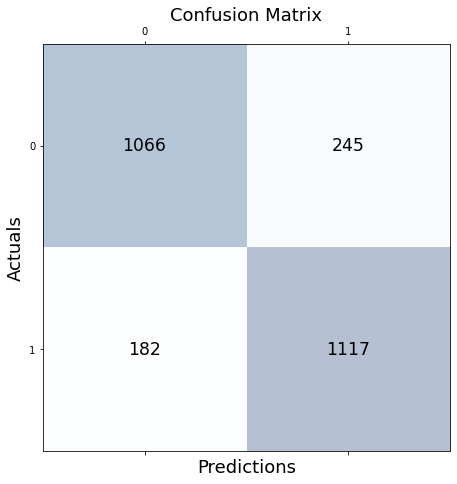

3. recall_score:  0.8598922247882987
4. precision_score:  0.8201174743024964
5. f1_score:  0.8395340097707629
6. Biểu đồ ROC của mô hình:


C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


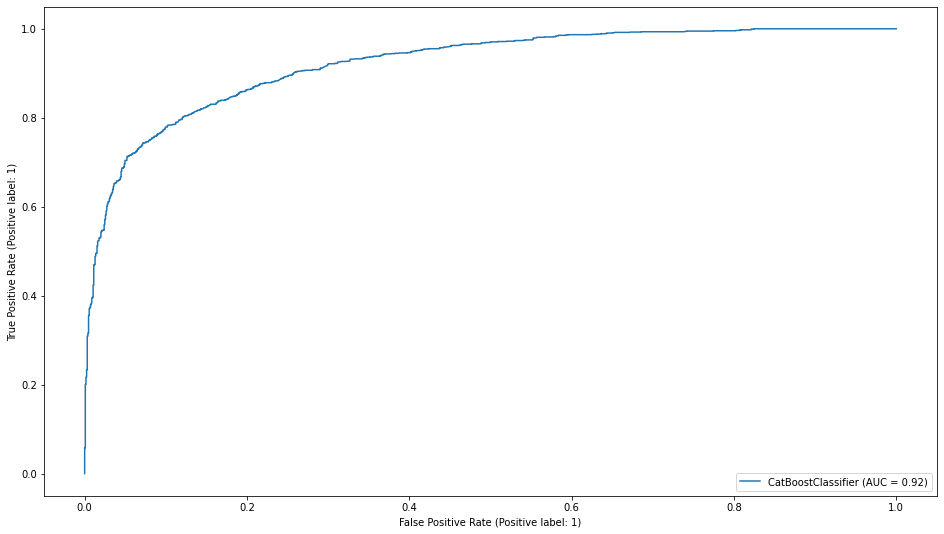

In [117]:
from catboost import CatBoostClassifier

model_catboss = CatBoostClassifier(learning_rate = 0.1, depth = 8, rsm = 1)

model_catboss.fit(X_train, Y_train)

#Prediction
cast_modelprediction=model_catboss.predict(X_test)

evaluate_model (model_catboss, X_test, y_test, cast_modelprediction)

# **Deep Learning**

# **ANN**

In [118]:
# Import the necessary libraries for ANN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Create a Sequential Neural Network model 
model = Sequential()
# Create an Input and a Hidden Layer
model.add(Dense(units=50,activation="relu",kernel_initializer="he_uniform"))
# Create an Output Layer
model.add(Dense(units=1,activation="sigmoid"))
# Now, my model is ready to compile
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
model.fit(X_train,y_train,batch_size=64,epochs=100)

In [ ]:
model.summary()

In [ ]:
# Predict the X_test results
y_pred = model.predict(X_test)

In [ ]:
y_pred_label = []
for i in range(0, len(y_pred)):
  if y_pred[i] >= 0.5:
    y_pred_label.append(1)
  else:
    y_pred_label.append(0)

In [ ]:
print("Các chỉ số đánh giá mức độ hiệu quả của mô hình: ")
#Accuracy
print("1. Accuracy:",metrics.accuracy_score(y_pred_label,y_test))
# confusion_matrix
print('2. confusion_matrix:')
print(confusion_matrix(y_pred_label,y_test))
# recall_score
print('3. recall_score: ', recall_score(y_pred_label,y_test))
# precision_score
print('4. precision_score: ', precision_score(y_pred_label,y_test))
# f1_score
print('5. f1_score: ', f1_score(y_pred_label,y_test))

# **LSTM**

In [ ]:
# Import the necessary libraries for ANN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Dropout

In [ ]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

In [ ]:
regressor.summary()

In [ ]:
# Predict the X_test results
y_pred = regressor.predict(X_test)

In [ ]:
y_pred_label = []
for i in range(0, len(y_pred)):
  if y_pred[i] >= 0.5:
    y_pred_label.append(1)
  else:
    y_pred_label.append(0)

In [ ]:
print("Các chỉ số đánh giá mức độ hiệu quả của mô hình: ")
#Accuracy
print("1. Accuracy:",metrics.accuracy_score(y_pred_label,y_test))
# confusion_matrix
print('2. confusion_matrix:')
print(confusion_matrix(y_pred_label,y_test))
# recall_score
print('3. recall_score: ', recall_score(y_pred_label,y_test))
# precision_score
print('4. precision_score: ', precision_score(y_pred_label,y_test))
# f1_score
print('5. f1_score: ', f1_score(y_pred_label,y_test))

# ***Kết thúc!***